In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from new_analysis_utils import *

%load_ext rpy2.ipython
sns.set_style('whitegrid')

In [3]:
sns.set_style('whitegrid')  # why does this need to be run twice?!

# Setup

In [22]:
EXPERIMENT = 5
figs = Figures(path=f'figs/{EXPERIMENT}')
figure = figs.plot
fb_order = ['none', 'action', 'meta', 'video']

def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

def write_percent(name, x):
    write_tex(name, f'{x * 100:.1f}\\%')

def read(stage, name):
    loader = pd.read_csv if name.endswith('csv') else pd.read_json
    df = loader(f'../data/{EXPERIMENT}/stage{stage}/{name}')
    df = drop_nan_cols(df).set_index('wid')
    parse_json(df)
    return df

participants = read(1, 'participants.csv').rename(columns={'completed': 'completed_stage1'})
survey = read(1, 'survey.csv')
stage1 = read(1, 'trials.csv')
stage2 = read(2, 'trials.json')
bonus = read(2, 'bonus.csv').bonus

# Drop participants who didn't finish both sections
# Note: they are still in the participants dataframe for computing retention rates
participants['completed_stage2'] = (stage2.reset_index().wid.value_counts() == 8)
participants.completed_stage2 = participants.completed_stage2.fillna(False)
pdf = participants.query('completed_stage2').copy()
keep = list(pdf.index)
stage1 = stage1.query('wid == @keep').copy()
stage2 = stage2.query('wid == @keep').copy()

stage2['planning_cost'] = stage2.planning_time / 1000
recomputed_bonus = (350 - (stage2.planning_cost + stage2.route_cost)).clip(0) / 1000
error = abs(recomputed_bonus - stage2.bonus)
assert error.mean() < .001
assert error.max() < .05 # one bad trial

stage1['feedback'] = pdf.feedback
stage2['feedback'] = pdf.feedback
pdf['bonus'] = bonus
stage2['n_click'] = stage2.reveals.apply(len)
pdf['stage1_n_click'] = stage1.groupby('wid').n_clicks.mean()
pdf['stage2_n_click'] = stage2.groupby('wid').n_click.mean()
pdf['route_cost'] = stage2.groupby('wid').route_cost.mean()
pdf['planning_cost'] = stage2.groupby('wid').planning_cost.mean()

nice_names['route_cost'] = 'Route Cost'

In [23]:
print(pdf.previously_participated.value_counts())
write_tex('N-drop-previous', sum(pdf.previously_participated != "No"))
pdf = pdf.query('previously_participated == "No"')
keep = list(pdf.index)
stage1 = stage1.query('wid == @keep')
stage2 = stage2.query('wid == @keep')
# assert set(stage2.index) == set(stage1.index) == set(pdf.index)

No          450
Yes          56
Not sure     20
Name: previously_participated, dtype: int64
wrote "76" to "stats/5/N-drop-previous.tex"


# Demographics

In [24]:
def regularize_gender(s):
    d = {
        'man': 'male',
        'woman': 'female',
        'f': 'female',
        'm': 'male',
    }
    s = s.lower().strip()
    return d.get(s, s)

gender = pdf.sex.str.lower()  # not very woke, but this is what Prolific gives us.
age = pdf.age.apply(excepts(ValueError, int, lambda _: None))
age.loc[age < 18] = None

write_tex('base-pay', '')
write_tex('mean-age', f'{age.mean():.2f}')
write_tex('min-age', str(age.min()))
write_tex('max-age', str(age.max()))
write_tex("N-female", str(gender.value_counts()['female']))
write_tex("N-gender", gender.apply(lambda x: x in ('male', 'female')).sum())
write_tex("N-age", (~age.isna()).sum())
write_tex("mean-bonus", f'\${pdf.bonus.mean():.2f}')

write_tex("N-total", len(participants))
for fb, n in pdf.feedback.value_counts().items():
    write_tex(f'N-{fb}', str(n))

wrote "" to "stats/5/base-pay.tex"
wrote "33.31" to "stats/5/mean-age.tex"
wrote "18.0" to "stats/5/min-age.tex"
wrote "76.0" to "stats/5/max-age.tex"
wrote "188" to "stats/5/N-female.tex"
wrote "448" to "stats/5/N-gender.tex"
wrote "442" to "stats/5/N-age.tex"
wrote "\$nan" to "stats/5/mean-bonus.tex"
wrote "594" to "stats/5/N-total.tex"
wrote "115" to "stats/5/N-action.tex"
wrote "114" to "stats/5/N-video.tex"
wrote "111" to "stats/5/N-none.tex"
wrote "110" to "stats/5/N-meta.tex"


In [21]:
set(bonus.index) & set(pdf.index)

set()

In [26]:
N = participants.query('completed_stage1').groupby(['completed_stage2', 'feedback']).apply(len)

for fb in fb_order:
    write_tex(f'N-drop-{fb}', N[False, fb])
    write_percent(f'drop-rate-{fb}', N[False, fb] / N[:, fb].sum())
write_percent('drop-rate', N[False].sum() / N.sum())
write_tex('return-N', N[True].sum())

wrote "8" to "stats/5/N-drop-none.tex"
wrote "5.6\%" to "stats/5/drop-rate-none.tex"
wrote "12" to "stats/5/N-drop-action.tex"
wrote "8.3\%" to "stats/5/drop-rate-action.tex"
wrote "11" to "stats/5/N-drop-meta.tex"
wrote "8.0\%" to "stats/5/drop-rate-meta.tex"
wrote "11" to "stats/5/N-drop-video.tex"
wrote "7.7\%" to "stats/5/drop-rate-video.tex"
wrote "7.4\%" to "stats/5/drop-rate.tex"
wrote "526" to "stats/5/return-N.tex"


# Transfer performance

In [27]:
stage2['score'] = stage2.bonus * 1000
pdf['score'] = stage2.groupby('wid').score.mean()

In [28]:
N_BOOT = 10000

def ci(xs):
    return np.quantile(xs, [0.025, 0.975])

def boot_means(X, n=N_BOOT):
    r = {}
    for fb in fb_order:
        x = X.loc[fb]
        means = [x.sample(frac=1, replace=True).mean() for _ in range(n)]
        r[fb] = np.array(means)
    return r

def write_means(var, units='points/trial'):
    X = pdf.set_index('feedback')[var]
    bm = boot_means(X)
    for fb in fb_order:
        x = X.loc[fb].mean()
        a, b = ci(bm[fb])
        if fb == 'meta':
            tex = (rf'${x:.2f}$ {units}; (95\% CI: [${a:.2f}$, ${b:.2f}$])')
        else:
            tex = (rf'${x:.2f}$ {units}; 95\% CI: [${a:.2f}$, ${b:.2f}$]')
        write_tex(f'{var}-mean-{fb}', tex)

In [29]:
def plot_transfer(outcome):
    plt.figure(figsize=(6, 2.5))
    sns.swarmplot('feedback', outcome, data=pdf, palette=palette, alpha=0.5, order=fb_order)
    sns.pointplot('feedback', outcome, data=pdf, palette=palette, order=fb_order, 
                  scale=1, capsize=0.1, markers='o')
    plt.xlabel('Feedback')
    plt.ylabel(nice_names[outcome])
    # test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()
    
def write_kruskal(name):
    out = %R kruskal.test($name ~ feedback, data=rdf)
    out = dict(out.items())
    df = out["parameter"][0]
    p = pval(out["p.value"][0])
    stat = out["statistic"][0]
    write_tex(f'{name}-kruskal', rf'$H = {stat:.3f}, {p}$')

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std =  np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

import re
def write_independence_test(y, a, b, alternative='two.sided'):
    # oddly, feedback == b tests a > b
    out = %R independence_test($y ~ feedback == "$b",\
                               data=filter(rdf, feedback %in% c("$a", "$b")),\
                               alternative="$alternative")
    out = str(out)
    match = re.search('Z = (.*), p-value = (.*)', out)
    try:
        z, p = map(float, match.groups())
    except:
        print('Cannot parse independence test')
        print(out)
        raise Exception()
    
    x = pdf.set_index('feedback')[y]
    d = cohen_d(x.loc[a], x.loc[b])
    write_tex(f'independence-{y}-{a}-{b}', f'$d = ${d:.2f}, Z = {z:.2f}, {pval(p)}$')

def write_comparisons(y):
    for fb in ['none', 'action', 'video']:
        write_independence_test(y, 'meta', fb)
    
    for fb in ['none', 'action']:
        write_independence_test(y, fb, 'video')

rdf = pdf[['feedback', 'score', 'route_cost', 'stage2_n_click', 'planning_cost']]

In [30]:
%%R -i rdf
library(dplyr)
library(coin)
rdf$feedback = relevel(factor(rdf$feedback), ref="video")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: survival



## Total Score

figs/5/transfer_score.pdf


<function new_analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

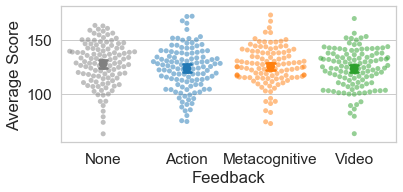

In [31]:
figure(outcome='score')(plot_transfer)

In [12]:
write_means('score')

wrote "$127.67$ points/trial; 95\% CI: [$123.83$, $131.39$]" to "stats/5/score-mean-none.tex"
wrote "$123.29$ points/trial; 95\% CI: [$119.64$, $126.95$]" to "stats/5/score-mean-action.tex"
wrote "$125.25$ points/trial; (95\% CI: [$121.94$, $128.61$])" to "stats/5/score-mean-meta.tex"
wrote "$123.09$ points/trial; 95\% CI: [$119.65$, $126.43$]" to "stats/5/score-mean-video.tex"


In [33]:
write_kruskal('score')

wrote "$H = 5.087, p = .166$" to "stats/5/score-kruskal.tex"


In [14]:
write_comparisons('score')

wrote "$d = $-0.13, Z = -0.95, p = .344$" to "stats/5/independence-score-meta-none.tex"
wrote "$d = $0.10, Z = 0.77, p = .443$" to "stats/5/independence-score-meta-action.tex"
wrote "$d = $0.12, Z = 0.89, p = .373$" to "stats/5/independence-score-meta-video.tex"
wrote "$d = $0.24, Z = 1.79, p = .074$" to "stats/5/independence-score-none-video.tex"
wrote "$d = $0.01, Z = 0.08, p = .937$" to "stats/5/independence-score-action-video.tex"


## Route cost

figs/5/transfer_route_cost.pdf


<function new_analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

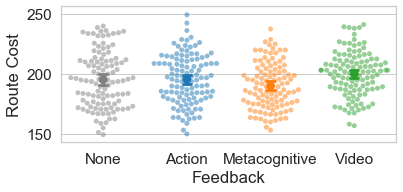

In [15]:
figure(outcome='route_cost')(plot_transfer)

In [16]:
write_means('route_cost')

wrote "$195.29$ points/trial; 95\% CI: [$190.96$, $199.39$]" to "stats/5/route_cost-mean-none.tex"
wrote "$195.62$ points/trial; 95\% CI: [$191.90$, $199.32$]" to "stats/5/route_cost-mean-action.tex"
wrote "$190.09$ points/trial; (95\% CI: [$186.60$, $193.61$])" to "stats/5/route_cost-mean-meta.tex"
wrote "$200.08$ points/trial; 95\% CI: [$196.75$, $203.45$]" to "stats/5/route_cost-mean-video.tex"


In [17]:
write_kruskal('route_cost')

wrote "$H = 13.638, p = .003$" to "stats/5/route_cost-kruskal.tex"


In [18]:
write_comparisons('route_cost')

wrote "$d = $-0.25, Z = -1.81, p = .070$" to "stats/5/independence-route_cost-meta-none.tex"
wrote "$d = $-0.28, Z = -2.08, p = .037$" to "stats/5/independence-route_cost-meta-action.tex"
wrote "$d = $-0.53, Z = -3.87, p < .001$" to "stats/5/independence-route_cost-meta-video.tex"
wrote "$d = $-0.23, Z = -1.71, p = .087$" to "stats/5/independence-route_cost-none-video.tex"
wrote "$d = $-0.23, Z = -1.73, p = .084$" to "stats/5/independence-route_cost-action-video.tex"


## Planning cost

figs/5/transfer_planning_cost.pdf


<function new_analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

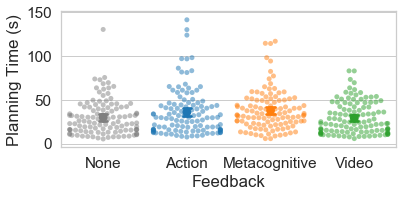

In [19]:
nice_names['planning_cost'] = 'Planning Time (s)'
figure(outcome='planning_cost')(plot_transfer)

In [20]:
write_means('planning_cost', 'seconds/trial')

wrote "$30.06$ seconds/trial; 95\% CI: [$26.48$, $33.89$]" to "stats/5/planning_cost-mean-none.tex"
wrote "$35.86$ seconds/trial; 95\% CI: [$31.16$, $40.79$]" to "stats/5/planning_cost-mean-action.tex"
wrote "$37.75$ seconds/trial; (95\% CI: [$33.66$, $42.03$])" to "stats/5/planning_cost-mean-meta.tex"
wrote "$29.04$ seconds/trial; 95\% CI: [$25.86$, $32.46$]" to "stats/5/planning_cost-mean-video.tex"


In [21]:
write_kruskal('planning_cost')

wrote "$H = 12.529, p = .006$" to "stats/5/planning_cost-kruskal.tex"


In [22]:
write_comparisons('planning_cost')

wrote "$d = $0.36, Z = 2.64, p = .008$" to "stats/5/independence-planning_cost-meta-none.tex"
wrote "$d = $0.08, Z = 0.57, p = .566$" to "stats/5/independence-planning_cost-meta-action.tex"
wrote "$d = $0.43, Z = 3.13, p = .002$" to "stats/5/independence-planning_cost-meta-video.tex"
wrote "$d = $0.05, Z = 0.40, p = .686$" to "stats/5/independence-planning_cost-none-video.tex"
wrote "$d = $0.30, Z = 2.25, p = .024$" to "stats/5/independence-planning_cost-action-video.tex"


## Number of clicks

figs/5/transfer_stage2_n_click.pdf


<function new_analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

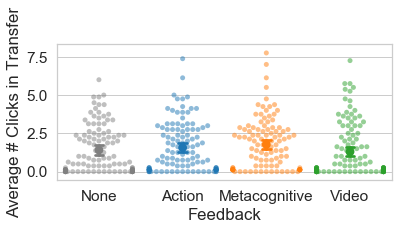

In [23]:
figure(outcome='stage2_n_click')(plot_transfer)

In [24]:
write_means('stage2_n_click')

wrote "$1.41$ points/trial; 95\% CI: [$1.13$, $1.70$]" to "stats/5/stage2_n_click-mean-none.tex"
wrote "$1.56$ points/trial; 95\% CI: [$1.28$, $1.86$]" to "stats/5/stage2_n_click-mean-action.tex"
wrote "$1.77$ points/trial; (95\% CI: [$1.48$, $2.09$])" to "stats/5/stage2_n_click-mean-meta.tex"
wrote "$1.30$ points/trial; 95\% CI: [$1.00$, $1.63$]" to "stats/5/stage2_n_click-mean-video.tex"


In [25]:
write_kruskal('stage2_n_click')

wrote "$H = 9.436, p = .024$" to "stats/5/stage2_n_click-kruskal.tex"


In [26]:
write_comparisons('stage2_n_click')

wrote "$d = $0.23, Z = 1.69, p = .091$" to "stats/5/independence-stage2_n_click-meta-none.tex"
wrote "$d = $0.13, Z = 0.99, p = .323$" to "stats/5/independence-stage2_n_click-meta-action.tex"
wrote "$d = $0.28, Z = 2.09, p = .036$" to "stats/5/independence-stage2_n_click-meta-video.tex"
wrote "$d = $0.07, Z = 0.51, p = .607$" to "stats/5/independence-stage2_n_click-none-video.tex"
wrote "$d = $0.16, Z = 1.19, p = .234$" to "stats/5/independence-stage2_n_click-action-video.tex"


# Backward planning

In [27]:
leaves = {3,4,7,8,11,12}

def stage1_backward(clicks):
    if not clicks:
        return False
    first = clicks[0]
    return first in leaves

stage1['backward'] = stage1.clicks.apply(stage1_backward)

pdf['stage1_backward'] = stage1.groupby('wid').backward.mean()
pdf.groupby('feedback').stage1_backward.mean()

feedback
action    0.300870
meta      0.782727
none      0.303604
video          NaN
Name: stage1_backward, dtype: float64

In [28]:
import networkx as nx

def make_graph(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

def get_goals(G):
    goal = [k for (k, v) in G.out_degree if v == 0]
    return set(goal)

def click_goal_first(row):
    if not row.reveals:
        return False
    else:
        goals = get_goals(row.graph)
        return row.reveals[0][0] in goals

def ever_goal(row):
    if not row.reveals:
        return False
    else:
        goals = get_goals(row.graph)
        return any(x[0] in goals for x in row.reveals)

def num_goal(row):
    if not row.reveals:
        return 0
    else:
        goals = get_goals(row.graph)
        return sum(x[0] in goals for x in row.reveals)
    
def prop_backward(row):
    if not row.reveals:
        return 0
    else:
        goals = get_goals(row.graph)
        first_clicks = row.reveals[:len(goals)]
        return sum(x[0] in goals for x in first_clicks) / len(first_clicks)

stage2['graph'] = stage2.edges.apply(make_graph)
stage2['backward'] = stage2.apply(click_goal_first, axis=1)
stage2['ever_goal'] = stage2.apply(ever_goal, axis=1)
stage2['num_goal'] = stage2.apply(num_goal, axis=1)
stage2['planned'] = stage2.n_click > 0
stage2['prop_backward'] = stage2.apply(prop_backward, axis=1)

pdf['stage2_backward'] = stage2.groupby('wid').backward.mean()
pdf['stage2_ever_goal'] = stage2.groupby('wid').ever_goal.mean()
pdf['stage2_num_goal'] = stage2.groupby('wid').num_goal.mean()
pdf['stage2_planned'] = stage2.groupby('wid').planned.mean()
pdf['prop_backward'] = stage2.groupby('wid').prop_backward.mean()

figs/5/learning_curve_backward.pdf


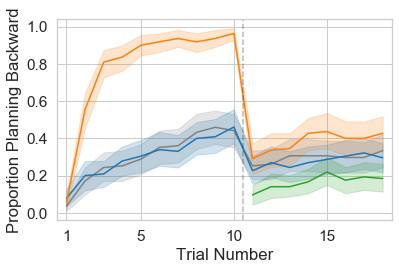

In [29]:
@figure()
def learning_curve_backward():
    plt.figure(figsize=(6, 3.7))
    s2 = stage2.copy()
    s2.trial_index += stage1.trial_index.max() + 1
    df = pd.concat([stage1, s2], sort=False)
    df.trial_index += 1
    sns.lineplot('trial_index', 'backward', hue='feedback', 
                 data=df, hue_order=fb_order, palette=palette)
    plt.xlabel('Trial Number')
    plt.ylabel('Proportion Planning Backward')
    plt.axvline(10.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    plt.legend().remove()
# reformat_legend()
    

In [30]:
rate = 100 * stage2.groupby('feedback').backward.mean()
for c in fb_order:
    r = rate[c]
    write_tex(f'backward-{c}-percent', f"${r:.1f}$\%")

# report_ratio(mdf.query('block == "test"').copy(), 'backward')

wrote "$29.5$\%" to "stats/5/backward-none-percent.tex"
wrote "$27.7$\%" to "stats/5/backward-action-percent.tex"
wrote "$38.3$\%" to "stats/5/backward-meta-percent.tex"
wrote "$16.4$\%" to "stats/5/backward-video-percent.tex"


In [31]:
rdf = pdf[['feedback', 'stage2_backward', 'stage2_planned', 'bonus', 'prop_backward']]

In [32]:
%%R -i rdf
rdf$feedback = relevel(factor(rdf$feedback), ref="video")

In [33]:
write_kruskal('stage2_backward')
for fb in ['none', 'action', 'video']:
    write_independence_test('stage2_backward', 'meta', fb)
    
for fb in ['none', 'action']:
    write_independence_test('stage2_backward', fb, 'video')

wrote "$H = 17.292, p < .001$" to "stats/5/stage2_backward-kruskal.tex"
wrote "$d = $0.21, Z = 1.57, p = .117$" to "stats/5/independence-stage2_backward-meta-none.tex"
wrote "$d = $0.26, Z = 1.94, p = .053$" to "stats/5/independence-stage2_backward-meta-action.tex"
wrote "$d = $0.61, Z = 4.35, p < .001$" to "stats/5/independence-stage2_backward-meta-video.tex"
wrote "$d = $0.37, Z = 2.74, p = .006$" to "stats/5/independence-stage2_backward-none-video.tex"
wrote "$d = $0.33, Z = 2.46, p = .014$" to "stats/5/independence-stage2_backward-action-video.tex"
